In [2]:

import jax
import os

#os.environ['CUDA_VISIBLE_DEVICES'] = '3'
print(jax.local_devices())



import jax
jax.config.update("jax_enable_x64", True)

import jax.numpy as jnp
from jax import random, vmap, jit, grad
import jax.scipy as scipy

from jax import random


import matplotlib.pyplot as plt

from utils_rough_pde import *
from utils_elliptic_coef import *

from scipy import integrate

import time

from jax.numpy import fft

from tqdm import tqdm

[CpuDevice(id=0)]


In [3]:
# Testing the sine transform
def discrete_sine_transform(y):
    n = y.shape[0]
    y_extended = jnp.concatenate([y,  -y[::-1]])
    y_fft = fft.rfft(y_extended)
    return (-y_fft.imag/(jnp.sqrt(2)*(n)))[:-1] # Removing the last spurious element 

vmap_dst = jit(vmap(discrete_sine_transform, in_axes=(0,)))
@jit
def dst_2d(A):
    # Receives a 2d array and returns the 2d discrete sine transform
    return vmap_dst(vmap_dst(A).T).T
@jit
def double_dst_2d(A):
    # Transform along the last 2 axes
    A = vmap(vmap(dst_2d, in_axes=0, out_axes=0), in_axes=1,out_axes=1)(A)
    # Transpose the axes
    A = jnp.transpose(A, (2, 3, 0, 1))
    # Transform along the last 2 axes
    A = vmap(vmap(dst_2d, in_axes=0, out_axes=0), in_axes=1,out_axes=1)(A)
    # Transpose the axes (going back to the original order)
    A = jnp.transpose(A, (2, 3, 0,1))
    return A

# Defining the second order elliptic operators 
def matern_kernel_2d(x_1, x_2, y_1, y_2, length_scale):
    r = jnp.sqrt((x_1 - y_1) ** 2 + (x_2 - y_2) ** 2)
    return (1 + jnp.sqrt(5)*r/length_scale + (5 / 3) * (r ** 2) / (length_scale ** 2)) * jnp.exp(-jnp.sqrt(5)*r/length_scale)

In [4]:
length_scale = 1.0
matern_kernel_tensor = jit(vmap(vmap(vmap(vmap(matern_kernel_2d, in_axes=(None, None,None, 0, None)), in_axes=(None, None, 0, None, None)), in_axes = (None, 0, None, None, None)), in_axes=(0, None, None, None, None)))

# 2D Elliptic PDE

In [28]:
lower = 0.0
upper = 1.0
domain = jnp.array([lower,upper])

# 2d grid 
n_points = 128
x = jnp.linspace(lower, upper, n_points, endpoint=False)
y = jnp.linspace(lower, upper, n_points, endpoint=False)
X, Y = jnp.meshgrid(x, y)

In [29]:
K_tensor = matern_kernel_tensor(x, x, y, y, length_scale)
K_tensor_transform = double_dst_2d(K_tensor)
K_tensor.shape, K_tensor_transform.shape

((128, 128, 128, 128), (128, 128, 128, 128))

We will consider 


We will solve the elliptic PDE with Dirichlet bc
\begin{aligned}
-\nu\Delta u + \sin(u) &= \xi \\
u &= 0
\end{aligned}

We will consider a manufactured solution

\begin{aligned}
u = \sum_{k=1}^\infty\sum_{l=1}^\infty u_{kl} (l^2 + k^2)^{-1 -\delta}\sin(2\pi k x) \sin(2\pi l y) \quad  u_{kl} \sim \mathcal{N}(0, 1)
\end{aligned}


In [30]:
plt.style.use('default')
#plt.style.use('default')

# 16:9 aspect ratio
width = 4
height = width * 3 / 4

In [101]:
def evaluate_function_sine_2d(x, y, k,l ,c):
    values = c*jnp.outer(jnp.sqrt(2)*jnp.sin(jnp.pi*k*x), jnp.sqrt(2)*jnp.sin(jnp.pi*l*y))
    values = jnp.where(k==0, c*jnp.outer(jnp.ones_like(x), jnp.sqrt(2)*jnp.sin(jnp.pi*l*y)), values)
    values = jnp.where(l==0, c*jnp.outer(jnp.sqrt(2)*jnp.sin(jnp.pi*k*x), jnp.ones_like(y)), values)
    return values

In [102]:
def evaluate_basis_sine_2d(x,y,c):
    # The frequency starts at 0
    f_1 = jnp.arange(0, c.shape[0])
    f_2 = jnp.arange(0, c.shape[0])
    return jnp.sum(jit(vmap(vmap(evaluate_function_sine_2d, in_axes=(None,None,0,None, 0), out_axes= -1), in_axes= (None, None, None, 0, 1),out_axes= -1))(x, y,f_1, f_2, c), axis = (2,3))#jit(vmap(vmap(evaluate_function_sine_2d, in_axes=(None,None,None,0, 1)), in_axes= (None, None, 0, None, 0)))(x, y,f_1, f_2, c)#vmap(evaluate_function_sine_2d, in_axes=(None,None,0,0, 0))(x, y,f_1, f_2, c)

In [161]:
key = random.PRNGKey(1215)
n_coef = 2**8
print("Number of coefficients: ", n_coef)

x_finest = jnp.linspace(lower,upper,n_coef, endpoint=False)
y_finest = jnp.linspace(lower,upper,n_coef, endpoint=False)
X, Y = jnp.meshgrid(x_finest, y_finest)
frequencies = jnp.arange(0, n_coef)
coef_u = random.normal(key, shape= (n_coef,n_coef))*jnp.outer(jnp.arange(1,n_coef+1), jnp.arange(1,n_coef+1))**(-2.0)
coef_u= coef_u.at[:,0].set(0)
coef_u= coef_u.at[0,:].set(0)


Number of coefficients:  256


In [162]:
coef_u

Array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00, -4.76733512e-02, -2.99982388e-02, ...,
        -1.04258594e-06, -5.14855418e-06,  2.87292015e-06],
       [ 0.00000000e+00, -1.10390363e-02, -9.06511270e-03, ...,
        -3.49567171e-07,  1.14584624e-06, -8.99347739e-07],
       ...,
       [ 0.00000000e+00, -1.89463123e-06,  2.68755242e-06, ...,
        -2.83796326e-10, -2.18287370e-10, -2.56240321e-10],
       [ 0.00000000e+00, -1.56416350e-06, -1.26001877e-06, ...,
        -1.86450178e-10,  2.25022058e-10, -1.90648653e-10],
       [ 0.00000000e+00, -3.15590186e-06,  1.57912501e-07, ...,
        -6.89182681e-11, -2.58458032e-10, -1.08053223e-10]],      dtype=float64)

In [160]:
u_values = evaluate_basis_sine_2d(x_finest,y_finest, coef_u)

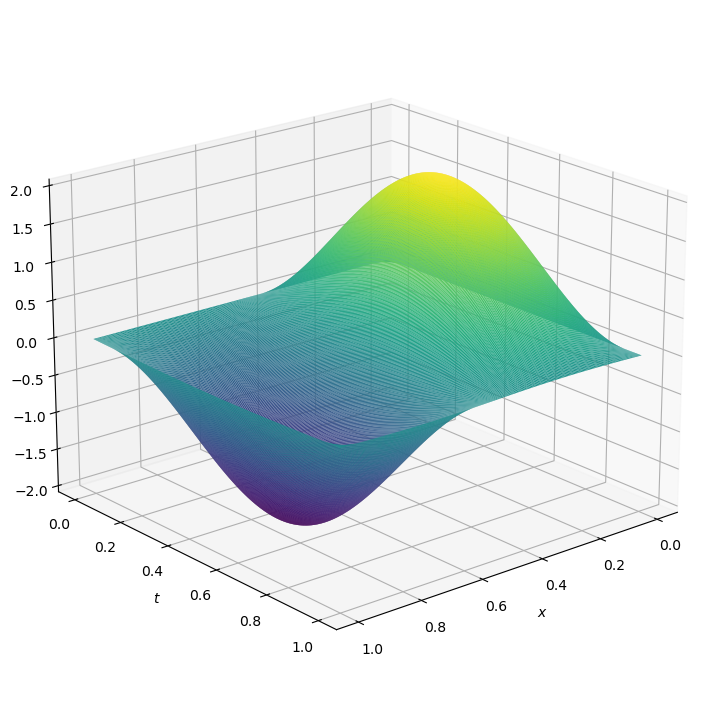

In [164]:
# Create a figure with two 3D subplots
fig,ax = plt.subplots(1, 1, figsize=(16, 9), subplot_kw={'projection': '3d'})

stride = 1
ax.plot_surface(X, Y, evaluate_function_sine_2d(x_finest, y_finest, 1,2 ,1),  cmap='viridis', rstride=stride, cstride=stride)
ax.view_init(elev=20, azim=50)  # Adjust elevation and azimuthal angle as desired
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$t$')
plt.show()

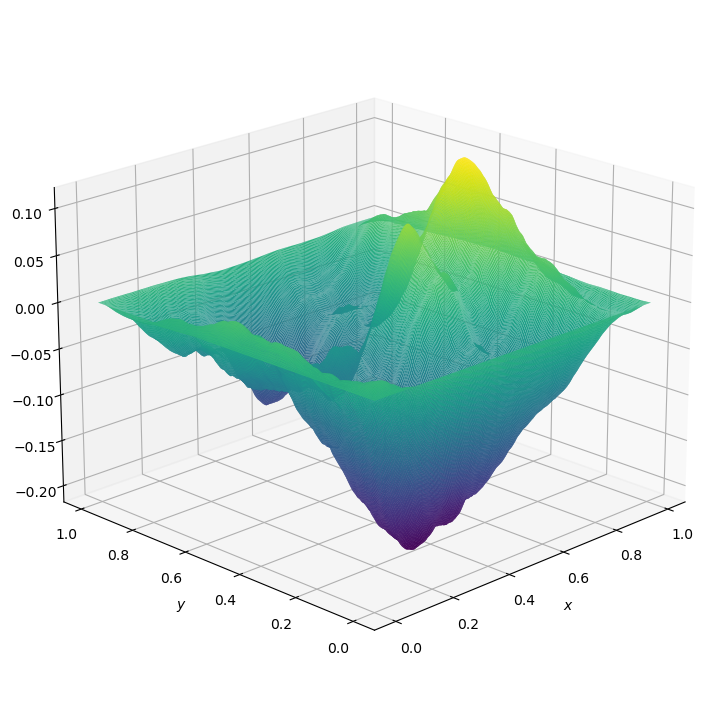

In [165]:
# Create a figure with two 3D subplots
fig,ax = plt.subplots(1, 1, figsize=(16, 9), subplot_kw={'projection': '3d'})

stride = 1
ax.plot_surface(X, Y, u_values,  cmap='viridis', rstride=stride, cstride=stride)
ax.view_init(elev=20, azim=225)  # Adjust elevation and azimuthal angle as desired
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()

In [159]:
u_values.shape

(128, 128)

# We will compute the DST in 2 dimensions

In [3]:
lower = 0.0
upper = 1.0
domain = jnp.array([lower,upper])

# 2d grid 
n_points = 4
x = jnp.linspace(lower, upper, n_points, endpoint=False)
y = jnp.linspace(lower+1, upper+1, n_points, endpoint=False)
X, Y = jnp.meshgrid(x, y)

In [4]:
x

Array([0.  , 0.25, 0.5 , 0.75], dtype=float64)

In [5]:
X.shape, Y

((4, 4),
 Array([[1.  , 1.  , 1.  , 1.  ],
        [1.25, 1.25, 1.25, 1.25],
        [1.5 , 1.5 , 1.5 , 1.5 ],
        [1.75, 1.75, 1.75, 1.75]], dtype=float64))

In [6]:
# Defining the second order elliptic operators 
def matern_kernel_2d(x_1, x_2, y_1, y_2, length_scale):
    r = jnp.sqrt((x_1 - y_1) ** 2 + (x_2 - y_2) ** 2)
    return (1 + jnp.sqrt(5)*r/length_scale + (5 / 3) * (r ** 2) / (length_scale ** 2)) * jnp.exp(-jnp.sqrt(5)*r/length_scale)

In [7]:
length_scale = 1.0
matern_kernel_tensor = jit(vmap(vmap(vmap(vmap(matern_kernel_2d, in_axes=(None, None,None, 0, None)), in_axes=(None, None, 0, None, None)), in_axes = (None, 0, None, None, None)), in_axes=(0, None, None, None, None)))

In [8]:
K_tensor = matern_kernel_tensor(x, x, y, y, length_scale)

In [9]:
# Checking that the tensor is correct
for i in range(n_points):
    for j in range(n_points):
        for k in range(n_points):
            for l in range(n_points):
                assert K_tensor[i,j,k,l] == matern_kernel_2d(x[i], x[j], y[k], y[l], length_scale)

In [10]:
# Testing the sine transform
def discrete_sine_transform(y):
    n = y.shape[0]
    y_extended = jnp.concatenate([y,  -y[::-1]])
    y_fft = fft.rfft(y_extended)
    return (-y_fft.imag/(jnp.sqrt(2)*(n)))[:-1] # Removing the last spurious element 

In [11]:
def vectorize_function(f, ndim):
    for _ in range(ndim):
        f = jax.vmap(f)
    return f

f_test = lambda x: x**2

f_test_vectorized = vectorize_function(f_test, 4)

In [12]:
K_test = f_test_vectorized(K_tensor)
# Checking that the tensor is correct
for i in range(n_points):
    for j in range(n_points):
        for k in range(n_points):
            for l in range(n_points):
                assert K_test[i,j,k,l] == f_test(K_tensor[i,j,k,l])


In [13]:
vmap_dst = jit(vmap(discrete_sine_transform, in_axes=(0,)))
@jit
def dst_2d(A):
    # Receives a 2d array and returns the 2d discrete sine transform
    return vmap_dst(vmap_dst(A).T).T

In [14]:
i,j = 0,2
dst_2d(K_tensor[i,j]).shape

(4, 4)

In [15]:
def test_function(A):
    return A**2

# Create a 4D tensor of size NxNxNxN
N = 4
tensor_4d = jnp.arange(N**4).reshape(N, N, N, N)
temp_tensor = vmap(vmap(test_function, in_axes=0, out_axes=0), in_axes=1, out_axes= 1)(tensor_4d)

In [16]:
for i in range(N):
    for j in range(N):
        #assert jnp.allclose(test_function(tensor_4d[i,j]), temp_tensor[i,j])
        print(jnp.mean(jnp.abs(test_function(tensor_4d[i,j])-temp_tensor[i,j])))

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [17]:
i, j = 1,2

In [18]:
K_trans_1 = vmap(vmap(dst_2d, in_axes=0, out_axes=0), in_axes=1,out_axes=1)(K_tensor)
K_trans_1[i,j]

Array([[-0.        , -0.        , -0.        , -0.        ],
       [-0.        ,  0.22995764,  0.03764908,  0.03915226],
       [ 0.        ,  0.04809114,  0.01003593,  0.0083947 ],
       [-0.        ,  0.04098363,  0.00706518,  0.0070257 ]],      dtype=float64)

In [23]:
# CHecking our vmap
for i in range(n_points):
    for j in range(n_points):
        #print(jnp.mean(jnp.abs(K_trans_1[i,j]- dst_2d(K_tensor[i,j]))))
        assert jnp.allclose(K_trans_1[i,j], dst_2d(K_tensor[i,j]))


In [24]:
tensor_intermediate = vmap(vmap(dst_2d, in_axes=0, out_axes=0), in_axes=1,out_axes=1)
#dst_tensor = vmap(vmap(tensor_intermediate, in_axes=2, out_axes=2), in_axes=3,out_axes=3)(K_tensor)

In [25]:
jnp.swapaxes(K_tensor, 0, 1).shape

(4, 4, 4, 4)

In [26]:
K_tensor[0,1,2,3]

Array(0.11533482, dtype=float64)

In [27]:
jnp.transpose(K_tensor, (2, 3, 0, 1))[2,3,0,1]

Array(0.11533482, dtype=float64)

In [28]:
@jit
def double_dst_2d(A):
    # Transform along the last 2 axes
    A = vmap(vmap(dst_2d, in_axes=0, out_axes=0), in_axes=1,out_axes=1)(A)
    # Transpose the axes
    A = jnp.transpose(A, (2, 3, 0, 1))
    # Transform along the last 2 axes
    A = vmap(vmap(dst_2d, in_axes=0, out_axes=0), in_axes=1,out_axes=1)(A)
    # Transpose the axes (going back to the original order)
    A = jnp.transpose(A, (2, 3, 0,1))
    return A

In [29]:
K_tensor_transform = double_dst_2d(K_tensor)

In [30]:
tensor_intermediate = vmap(vmap(dst_2d, in_axes=0, out_axes=0), in_axes=1,out_axes=1)(K_tensor)
tensor_intermediate = jnp.transpose(tensor_intermediate, (2, 3, 0, 1))
tensor_intermediate = vmap(vmap(dst_2d, in_axes=0, out_axes=0), in_axes=1,out_axes=1)(tensor_intermediate)

In [31]:
i, j,k,l = 3,2,3,0

In [32]:
tensor_intermediate[k,l,i,j], K_tensor_transform[i,j,k,l]

(Array(-0., dtype=float64), Array(-0., dtype=float64))

In [33]:
[k,l,i,j]

[3, 0, 3, 2]

In [34]:
tensor_intermediate[i,j,k,l]

Array(-0., dtype=float64)

In [58]:
lower = 0.0
upper = 1.0
domain = jnp.array([lower,upper])

# 2d grid 
n_points = 64
x = jnp.linspace(lower, upper, n_points, endpoint=False)
y = jnp.linspace(lower, upper, n_points, endpoint=False)
X, Y = jnp.meshgrid(x, y)

In [59]:
K_tensor = matern_kernel_tensor(x, x, y, y, length_scale)

In [60]:
K_tensor.shape

(64, 64, 64, 64)

In [38]:
# def integrate_sine(points, k, l, K):
#      G = K*jnp.outer(jnp.sqrt(2)*jnp.sin(jnp.pi*k*points), jnp.sqrt(2)*jnp.sin(jnp.pi*l*points))
#      return integrate.trapezoid(integrate.trapezoid(G, points), points)

In [40]:
def create_sine(x,y,z,w, i,j,k,l):
    return jnp.sqrt(2)*jnp.sin(jnp.pi*i*x)*jnp.sqrt(2)*jnp.sin(jnp.pi*j*y)*jnp.sqrt(2)*jnp.sin(jnp.pi*k*z)*jnp.sqrt(2)*jnp.sin(jnp.pi*l*w)

create_sine_tensor = vmap(vmap(vmap(vmap(create_sine, in_axes = (None, None, None, 0, None, None, None, None)), in_axes = (None, None, 0, None, None, None, None, None)),  in_axes = (None, 0, None, None, None, None, None, None)), in_axes = (0, None, None, None, None, None, None, None))

In [55]:
from jax.scipy import integrate

In [79]:
i,j,k,l = 3, 3,3,3
sine_tensor = create_sine_tensor(x,x,y,y,i,j,k,l)
G = sine_tensor*K_tensor
integrate.trapezoid(integrate.trapezoid(integrate.trapezoid(integrate.trapezoid(G, y), y), x), x)

Array(0.00491721, dtype=float64)

In [80]:
K_tensor_transform = double_dst_2d(K_tensor)

In [81]:
K_tensor_transform[i,j,k,l]

Array(0.00502258, dtype=float64)

In [56]:
jnp.mean(G)

Array(0.0057384, dtype=float64)

In [51]:
m,n,o,p = 23,45, 7, 17
sine_tensor[m,n,o,p], create_sine(x[m],x[n],y[o],y[p], i,j,k,l)

(Array(0.57902026, dtype=float64), Array(0.57902026, dtype=float64))